School of Computer Sciences, USM<br>Semester 2, 2020/2021

# CDS513: Predictive Business Analytics - Group Project

## Time Series (TS) Analysis and Forecasting

##### Project Title
\> Improving Sales Performance of the Ecommerce Website for an Electronics Store using Predictive Business Analytics Techniques 

##### Group No
\> Group 3 \[Lee Yong Meng (P-COM0012/20) | Lee Kar Choon (P-COM0130/19) | Lim Hang Thing (P-COM0143/20)\]

##### Dataset
\> Purchase data: [Ecommerce Purchase History from Electronics Store](https://www.kaggle.com/mkechinov/ecommerce-purchase-history-from-electronics-store)

<img alt="Clock and electronic gadgets" src="https://images.unsplash.com/photo-1616175304583-ed54838016f3?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1950&q=80">

Photo by <a href="https://unsplash.com/@currentspaces?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Brandon Romanchuk</a> on <a href="https://unsplash.com/s/photos/clock-electronic?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

***

### Ecommerce Electronic sales trend analysis and sales forecasting

Programmer : Lee Kar Choon

### Step 1: Load Dataset

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import pmdarima as pm
import time

# from pandas.tseries import converter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import make_scorer

warnings.filterwarnings("ignore") # specify to ignore warning messages
# converter.register()
sns.set(rc={'figure.figsize':(15,6)})
%matplotlib inline

df_purchase = pd.read_csv('src/kz.csv')
df_cleaned = df_purchase.copy()


### Step 2: Pre-processing

In [2]:
df_cleaned['category_code'] = df_cleaned['category_code'].fillna('unknown_category')
df_cleaned['brand'] = df_cleaned['brand'].fillna('unknown_brand')
df_cleaned['product_name'] = df_cleaned['category_code'] + '-' + df_cleaned['brand']
df_cleaned['category'] = df_cleaned['category_id'].astype(str)
df_cleaned['category'] = df_cleaned['category'] + '-' + df_cleaned['category_code']

display(df_cleaned.head())

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,product_name,category
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,electronics.tablet-samsung,2.268105426648171e+18-electronics.tablet
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,electronics.tablet-samsung,2.268105426648171e+18-electronics.tablet
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,electronics.audio.headphone-huawei,2.2681054301629978e+18-electronics.audio.headp...
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,electronics.audio.headphone-huawei,2.2681054301629978e+18-electronics.audio.headp...
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,unknown_category,karcher,217.57,1.515916e+18,unknown_category-karcher,2.26810547136784e+18-unknown_category


In [3]:
display(df_cleaned['category'].unique()[:10])
display(df_cleaned['category'].size)


array(['2.268105426648171e+18-electronics.tablet',
       '2.2681054301629978e+18-electronics.audio.headphone',
       '2.26810547136784e+18-unknown_category',
       '2.268105442636858e+18-furniture.kitchen.table',
       '2.268105428166509e+18-electronics.smartphone',
       '2.268105393848714e+18-appliances.kitchen.refrigerators',
       '2.2681054024470374e+18-appliances.personal.scales',
       '2.3744989140005924e+18-electronics.video.tv',
       '2.2681054100219494e+18-computers.components.cpu',
       '2.2681054027741932e+18-unknown_category'], dtype=object)

2633521

# *This cell takes up to 5 minutes to complete running.*

In [4]:
start_time = time.time()

df_cleaned = df_cleaned[['event_time', 'category', 'price']]
df_cleaned['event_time'] = pd.to_datetime(df_cleaned['event_time'])
df_cleaned['event_time'] = df_cleaned["event_time"].dt.date

end_time = time.time()
print('Time elapsed: ', end_time - start_time)

Time elapsed:  256.69225096702576


In [5]:
display(df_cleaned.head())
#display(np.sum(df_cleaned[['category', 'price']].isna()))
#display(df_cleaned['price'].isnull().sum())

,event_time,category,price
0,2020-04-24,2.268105426648171e+18-electronics.tablet,162.01
1,2020-04-24,2.268105426648171e+18-electronics.tablet,162.01
2,2020-04-24,2.2681054301629978e+18-electronics.audio.headp...,77.52
3,2020-04-24,2.2681054301629978e+18-electronics.audio.headp...,77.52
4,2020-04-24,2.26810547136784e+18-unknown_category,217.57


In [6]:
##drop rows with price == NaN
df_cleaned = df_cleaned[~df_cleaned['price'].isna()]
display(df_cleaned.shape)

##drop rows with event_time == 1970-01-01 year data
df_cleaned = df_cleaned[df_cleaned['event_time'] > dt.date(1970, 1, 1)]
display(df_cleaned.shape)

(2201567, 3)

(2186014, 3)

### Step 3: Exploring the dataset

In [7]:
##Check overall category unique and top counts
df_category_all = df_cleaned.groupby('category').agg({ 'price': ['mean','min','max','count']})
df_category_all = df_category_all.sort_values([('price','count')], ascending=False)
display(df_category_all.head(10))

price         \
                                                          mean    min   
category                                                                
2.268105428166509e+18-electronics.smartphone        302.831564  46.04   
2.2681054301629978e+18-electronics.audio.headphone   65.115374   0.23   
2.3744989140005924e+18-electronics.video.tv         458.729482  92.57   
2.268105392070329e+18-appliances.environment.va...  155.693218  37.01   
2.2681053899563999e+18-appliances.kitchen.washer    347.419603  90.02   
2.268105442636858e+18-furniture.kitchen.table        32.931493   8.89   
2.2681054418567176e+18-appliances.kitchen.kettle     34.070708   4.61   
2.2681054072201554e+18-computers.notebook           646.389867   0.00   
2.268105393848714e+18-appliances.kitchen.refrig...  528.568818  92.57   
2.2681054411017428e+18-appliances.kitchen.blender    66.642515  17.34   

                                                                      
                                                         max   count  
category                                                              
2.268105428166509e+18-electronics.smartphone         2314.79  335709  
2.2681054301629978e+18-electronics.audio.headphone    810.16   65637  
2.3744989140005924e+18-electronics.video.tv         50925.90   58804  
2.268105392070329e+18-appliances.environment.va...   2474.51   58127  
2.2681053899563999e+18-appliances.kitchen.washer     4629.58   51527  
2.268105442636858e+18-furniture.kitchen.table         324.05   49491  
2.2681054418567176e+18-appliances.kitchen.kettle      405.07   47723  
2.2681054072201554e+18-computers.notebook            5370.35   47155  
2.268105393848714e+18-appliances.kitchen.refrig...   9173.59   44634  
2.2681054411017428e+18-appliances.kitchen.blender     821.74   36540

In [8]:
df_cleaned = df_cleaned.sort_values([('event_time')], ascending=True)

display(df_cleaned['event_time'].min())
display(df_cleaned['event_time'].max())
display(df_cleaned[df_cleaned['event_time'] < dt.date(2020, 4, 1)].count())
display(df_cleaned['event_time'].unique()[:150])

display(df_cleaned[df_cleaned['event_time'] == dt.date(2020, 3, 5)].count())

datetime.date(2020, 1, 5)

datetime.date(2020, 11, 21)

event_time    716922
category      716922
price         716922
dtype: int64

array([datetime.date(2020, 1, 5), datetime.date(2020, 1, 6),
       datetime.date(2020, 1, 7), datetime.date(2020, 1, 8),
       datetime.date(2020, 1, 9), datetime.date(2020, 1, 10),
       datetime.date(2020, 1, 11), datetime.date(2020, 1, 12),
       datetime.date(2020, 1, 13), datetime.date(2020, 1, 14),
       datetime.date(2020, 1, 15), datetime.date(2020, 1, 16),
       datetime.date(2020, 1, 17), datetime.date(2020, 1, 18),
       datetime.date(2020, 1, 19), datetime.date(2020, 1, 20),
       datetime.date(2020, 1, 21), datetime.date(2020, 1, 22),
       datetime.date(2020, 1, 23), datetime.date(2020, 1, 24),
       datetime.date(2020, 1, 25), datetime.date(2020, 1, 26),
       datetime.date(2020, 1, 27), datetime.date(2020, 1, 28),
       datetime.date(2020, 1, 29), datetime.date(2020, 1, 30),
       datetime.date(2020, 1, 31), datetime.date(2020, 2, 1),
       datetime.date(2020, 2, 2), datetime.date(2020, 2, 3),
       datetime.date(2020, 2, 4), datetime.date(2020, 2, 5),
  

event_time    8308
category      8308
price         8308
dtype: int64

In [10]:
##Example
#2.268105426648171e+18-electronics.tablet
#2.268105428166509e+18-electronics.smartphone
#cat = input("Enter your value: ")
#print('category: ', cat)

##smartphone category analysis
cat = '2.268105428166509e+18-electronics.smartphone'
display(df_cleaned[df_cleaned['category'] == cat])

df_category = df_cleaned[df_cleaned['category'] == cat]

df_category = df_category.groupby(['event_time'], sort = True).agg( {'price': 'sum'})
display(df_category)

period_end_date = df_cleaned['event_time'].max()
cat_start_date = df_category.index.min()
cat_end_date = df_category.index.max()

date_range = []

i_date = cat_start_date
while i_date <= period_end_date:
    #print(i_date)
    if (i_date not in df_category.index):
        date_range.append(i_date)
        
    i_date = i_date + dt.timedelta(days=1)

df_cat_zero = pd.DataFrame(index = date_range, columns = df_category.columns)
df_cat_zero = df_cat_zero.fillna(0.00)

df_cat_ = df_category.copy()

pdList = [df_cat_, df_cat_zero]
df_cat_result = pd.concat(pdList)
df_cat_result = df_cat_result.sort_index()


,event_time,category,price
57967,2020-01-05,2.268105428166509e+18-electronics.smartphone,173.13
57975,2020-01-05,2.268105428166509e+18-electronics.smartphone,184.93
57982,2020-01-05,2.268105428166509e+18-electronics.smartphone,162.01
58000,2020-01-05,2.268105428166509e+18-electronics.smartphone,569.19
57996,2020-01-05,2.268105428166509e+18-electronics.smartphone,138.63
...,...,...,...
2633311,2020-11-21,2.268105428166509e+18-electronics.smartphone,347.20
2633328,2020-11-21,2.268105428166509e+18-electronics.smartphone,925.67
2633322,2020-11-21,2.268105428166509e+18-electronics.smartphone,127.29
2633319,2020-11-21,2.268105428166509e+18-electronics.smartphone,162.01


,price
event_time,
2020-01-05,371539.63
2020-01-06,332321.50
2020-01-07,399448.31
2020-01-08,281893.94
2020-01-09,235279.72
...,...
2020-11-17,152207.24
2020-11-18,344539.81
2020-11-19,312322.91


In [11]:
## Functions
def PlotCategorySaleLineChart(data, columnName, title):
    plt.figure(figsize=(15,6))
    plt.plot(data.index, data[columnName])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sales (RM)')
    plt.show()

def CheckStationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('ADF TEST:')
    print('')
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))
        
def Differencing(data, columnName):
    df_shift = data.copy()
    df_shift['shift'] = data[columnName] - (data[columnName]).shift(1)
    return df_shift

def PlotACFPACF(data, columnName):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data[columnName].iloc[2:],lags=40,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data[columnName].iloc[2:],lags=40,ax=ax2)
    
# Relative error
def mean_relative_error(y_true, y_pred):
    import numpy as np
    relative_error = np.average(np.abs(y_true - y_pred) / y_true, axis=0)
    return relative_error


## ARIMA Modelling

### Step 1: Check Stationarity

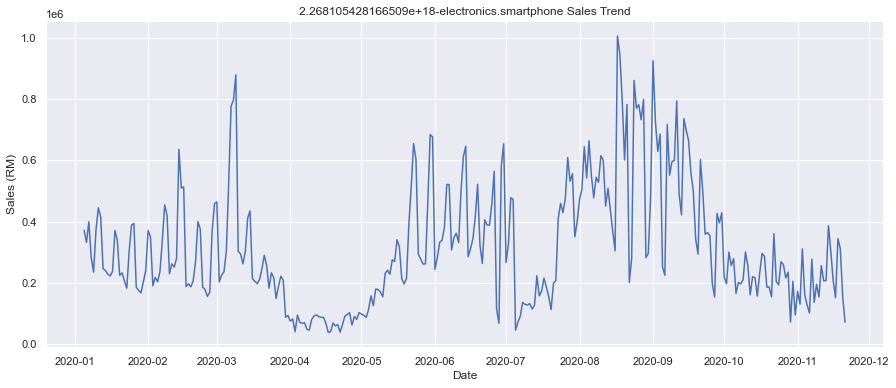

ADF TEST:

The test statistic: -2.164866
p-value: 0.219243
Critical Values:
1%: -3.451
5%: -2.871
10%: -2.572


In [12]:
PlotCategorySaleLineChart(df_cat_result, 'price', cat+' Sales Trend')

CheckStationarity(df_cat_result.price)


### Step 2: Diferrencing

ADF Test shows p-value 0.22 is more than 0.05, we does not reject the null hypothesis and the data is deemed non-stationary.
Then the data is needed to differenced, and check again by ADF Test.

ADF TEST:

The test statistic: -8.085826
p-value: 0.000000
Critical Values:
1%: -3.451
5%: -2.871
10%: -2.572


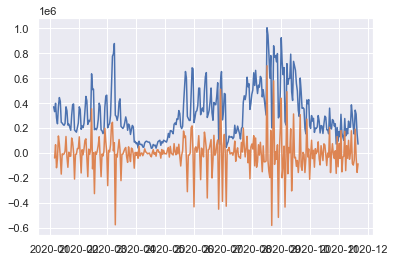

In [13]:
df_shift = Differencing(df_cat_result, 'price')
plt.plot(df_shift) 
CheckStationarity(df_shift['shift'].dropna())


ADF Test shows p-value 0.00 is less than 0.05, we reject the null hypothesis and the shifted data is deemed stationary.

### Step 3: Plot ACF and PACF to obtain p, d and q order.

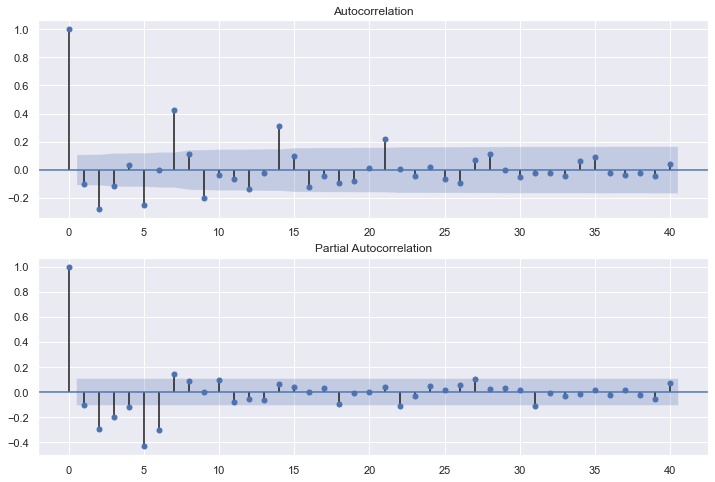

In [14]:
PlotACFPACF(df_shift,'shift')


In [15]:
auto_arima_fit = pm.auto_arima(df_cat_result.price, start_p=1, start_q=1,
                             max_p=13, max_q=13, m=12,
                             seasonal=True,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=8476.266, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8531.980, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8525.295, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8513.683, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8529.995, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=8474.294, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=8476.726, Time=0.08 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=8476.282, Time=0.50 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=8474.272, Time=0.26 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=8476.197, Time=0.45 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=8514.685, Time=0.13 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=8458.754, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=8459.401, Time=0.06 sec
 ARIMA(2,1,1)(2,0,0)[12]

Based on auto arima result, the best model is ARIMA(7,1,0) with the p, d, q value of 7, 1, 0 respectively. However the AIC is marked very high value at 8398.943.

### Step 4: Build ARIMA model and check on residual diagnostics

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  322
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -4190.456
Date:                Sun, 27 Jun 2021   AIC                           8396.912
Time:                        18:59:34   BIC                           8427.084
Sample:                    01-05-2020   HQIC                          8408.959
                         - 11-21-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3585      0.046     -7.736      0.000      -0.449      -0.268
ar.L2         -0.4428      0.043    -10.303      0.000      -0.527      -0.359
ar.L3         -0.4470      0.042    -10.662      0.0

,0
count,322.000000
mean,958.982616
std,114857.387925
min,-396014.013131
25%,-50118.781923
50%,-1100.705962
75%,51991.788217
max,552806.783010


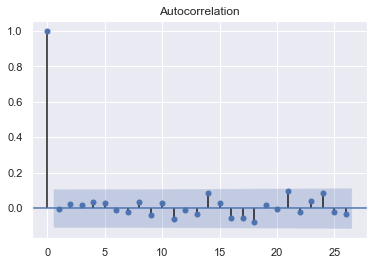

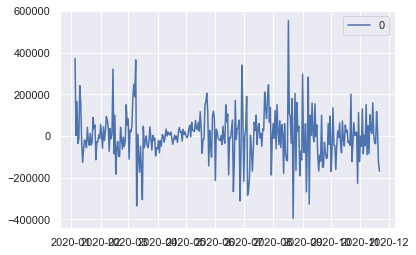

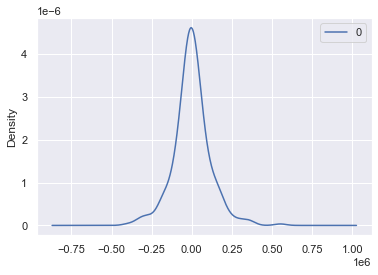

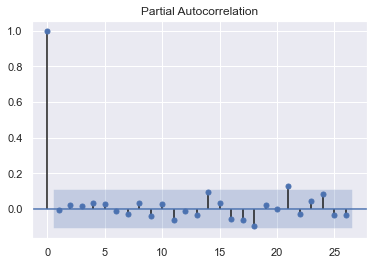

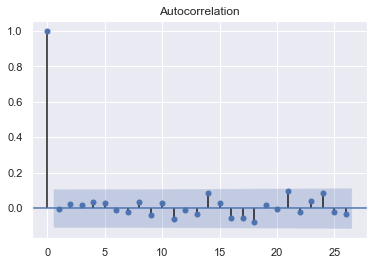

In [16]:
arima_model = sm.tsa.arima.ARIMA(df_cat_result.price,order=(7,1,0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

residuals = pd.DataFrame(arima_model_fit.resid)
display(residuals.plot())
display(residuals.plot(kind='kde'))
display(residuals.describe())

plot_pacf(residuals)
plot_acf(residuals)

#display(auto_arima_fit)
#display(df_cat_result.tail(50))

### Step 5: Check test set output perfomance from ARIMA(7,1,0)

ARIMA(7,1,0)
MAE: 74608.02
RMSE: 94626.67
MSE: 8954206811.4
MRE: 0.5


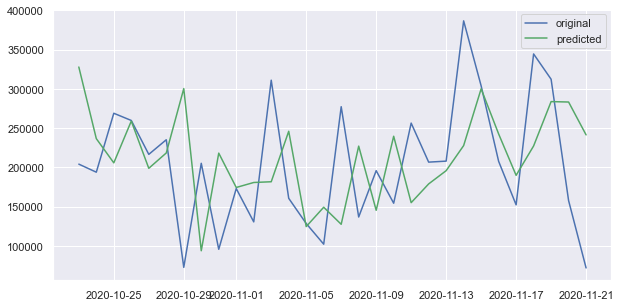

In [17]:
test_days = 30
train = df_cat_result.iloc[:-test_days]
test = df_cat_result.iloc[-test_days:]
test_start = len(train)
#df_test = df_cat_result[-test_days:]
#df_test = df_cat_result
#display(df_cat_result.head(10))
#display(df_test)

y_pred_ = arima_model_fit.predict(test_start, test_start +test_days-1)
y_true_ = test.price
#display(y_pred_)
rmse1= rmse(y_true_, y_pred_)
mse1 = mean_squared_error(y_true_, y_pred_)
mae1 = mean_absolute_error(y_true_, y_pred_)
mre1 = mean_relative_error(y_true_, y_pred_)

print('ARIMA(7,1,0)')
print('MAE: {0}'.format(str(round(mae1,2))))
print('RMSE: {0}'.format(str(round(rmse1,2))))
print('MSE: {0}'.format(str(round(mse1,2))))
print('MRE: {0}'.format(str(round(mre1,2))))

plt.figure(figsize=(10,5))
plt.plot(test,label = 'original', color='b' )
plt.plot(y_pred_,label = 'predicted', color='g' )
plt.legend()


#plt.plot(df_cat_result.price[:test_days],label = 'original', color='blue' )
#plt.plot(arima_model_fit.predict(0,test_days),label = 'predicted', color='g' )
#plt.legend()


### Step 6: Multi-Step Out-of-Sample Forecast

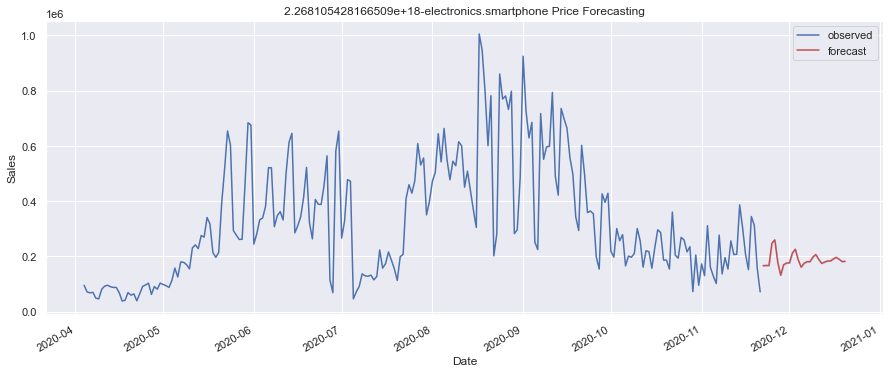

In [18]:
forecast_days = 30
view_days = 90

forecast = arima_model_fit.forecast(steps=forecast_days)
df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start=period_end_date, periods=forecast_days, freq='D'))
#print(df_forecast.head(forecast_days))

ci = df_forecast.values
ax = df_cat_result[view_days:].price.plot(label='observed', figsize=(15, 6))
df_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(df_forecast.index,
                ci[:,-1],
                ci[:,0], color='b', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title(cat +' Price Forecasting')
plt.legend()
plt.show()

# XGBoost Time Series Method

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from numpy import asarray
from pandas import concat

def ConstructCategoryDateData(data, cat, timeColumName, priceColumn):
    df_category = data[data['category'] == cat]
    df_category = df_category.groupby([timeColumName], sort = True).agg( { priceColumn: 'sum'})
    #display(df_category)

    period_end_date = data[timeColumName].max()
    cat_start_date = df_category.index.min()
    cat_end_date = df_category.index.max()

    date_range = []

    i_date = cat_start_date
    while i_date <= period_end_date:
        #print(i_date)
        if (i_date not in df_category.index):
            date_range.append(i_date)

        i_date = i_date + dt.timedelta(days=1)

    df_cat_zero = pd.DataFrame(index = date_range, columns = df_category.columns)
    df_cat_zero = df_cat_zero.fillna(0.00)

    df_cat_ = df_category.copy()

    pdList = [df_cat_, df_cat_zero]
    df_cat_result = pd.concat(pdList)
    df_cat_result = df_cat_result.sort_index()
    return df_cat_result

def series_to_supervised(data, n_in=1, n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0,n_out):
        cols.append(df.shift(-i))
    
    agg = concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg.values

def train_test_split(data, n_test):
    return data[:-n_test,:], data[-n_test:,:]

def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]

    for i in range(len(test)):
        testX, testy = test[i, :-1], test [i, -1]
        #display(testX)
        yhat = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    #display(predictions)
    error = mean_absolute_error(test[:,-1], predictions)
    return error, test[:,-1], predictions

def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

### Step 1: Transform data into supervised problem and check on the feature correlationship

In [20]:
lag_days = 10

df_supervised = series_to_supervised(df_cat_result, lag_days)
df_supervised = pd.DataFrame(df_supervised)
display(df_supervised[:10])

trainX, trainy = df_supervised.iloc[:, :-1], df_supervised.iloc[:, -1]

#trainX, trainy = df_supervised[:, :-1], df_supervised[:, -1]
x = pd.concat([trainX, trainy], axis=1)
cor = x.corr()
cor



#display(df_supervised[:10])

,0,1,2,3,4,5,6,7,8,9,10
0,371539.63,332321.50,399448.31,281893.94,235279.72,372701.50,445244.95,414983.17,246508.25,240618.94,228710.92
1,332321.50,399448.31,281893.94,235279.72,372701.50,445244.95,414983.17,246508.25,240618.94,228710.92,222972.14
2,399448.31,281893.94,235279.72,372701.50,445244.95,414983.17,246508.25,240618.94,228710.92,222972.14,237847.37
3,281893.94,235279.72,372701.50,445244.95,414983.17,246508.25,240618.94,228710.92,222972.14,237847.37,371044.52
4,235279.72,372701.50,445244.95,414983.17,246508.25,240618.94,228710.92,222972.14,237847.37,371044.52,339160.75
5,372701.50,445244.95,414983.17,246508.25,240618.94,228710.92,222972.14,237847.37,371044.52,339160.75,225211.00
6,445244.95,414983.17,246508.25,240618.94,228710.92,222972.14,237847.37,371044.52,339160.75,225211.00,232705.95
7,414983.17,246508.25,240618.94,228710.92,222972.14,237847.37,371044.52,339160.75,225211.00,232705.95,207011.99
8,246508.25,240618.94,228710.92,222972.14,237847.37,371044.52,339160.75,225211.00,232705.95,207011.99,182912.59
9,240618.94,228710.92,222972.14,237847.37,371044.52,339160.75,225211.00,232705.95,207011.99,182912.59,304022.31


,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.741284,0.536757,0.474396,0.471693,0.459199,0.581135,0.701980,0.598576,0.437166,0.384392
1,0.741284,1.000000,0.741569,0.535607,0.474509,0.472757,0.459821,0.580469,0.701590,0.599584,0.438569
2,0.536757,0.741569,1.000000,0.740556,0.535536,0.475254,0.473469,0.459491,0.580336,0.702169,0.600247
3,0.474396,0.535607,0.740556,1.000000,0.740807,0.535393,0.473530,0.473109,0.459029,0.579477,0.699828
4,0.471693,0.474509,0.535536,0.740807,1.000000,0.740564,0.535235,0.474194,0.473606,0.458646,0.578295
5,0.459199,0.472757,0.475254,0.535393,0.740564,1.000000,0.741520,0.536071,0.474973,0.474062,0.459217
6,0.581135,0.459821,0.473469,0.473530,0.535235,0.741520,1.000000,0.740315,0.535365,0.476546,0.476154
7,0.701980,0.580469,0.459491,0.473109,0.474194,0.536071,0.740315,1.000000,0.740041,0.535632,0.476042
8,0.598576,0.701590,0.580336,0.459029,0.473606,0.474973,0.535365,0.740041,1.000000,0.740332,0.535354
9,0.437166,0.599584,0.702169,0.579477,0.458646,0.474062,0.476546,0.535632,0.740332,1.000000,0.740816


In [21]:
display(cor.columns)
# Apple abs() to get the absolute value so no need to deal with negative correlations
cor_target = abs(cor[10])

# Selecting highly correlated features
# Say we set the correlation threshold to 0.45
relevant_features = cor_target[cor_target > 0.45]
relevant_features

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

2     0.600247
3     0.699828
4     0.578295
5     0.459217
6     0.476154
7     0.476042
8     0.535354
9     0.740816
10    1.000000
Name: 10, dtype: float64

by using the correlateion threshold of 0.45, There decide to use the lag value of 9 days.
However there is signifant drop between 8 (t-3) and 7 (t-4), we can try on the lag value of 3 days as well. 

### Step 2: GridSearch Hyperparameter Tuning of XGBoost

# *This cell takes approximately 10 minutes to complete running.*

In [22]:
#revised lag days
lag_days = 9
test_days = 30

def XGBoostGridSearch(df_cat_result, lag_days, test_days):
    rmse_score = make_scorer(rmse, greater_is_better = False)

    df_supervised = series_to_supervised(df_cat_result, lag_days)
    train, test = train_test_split(df_supervised, test_days)
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]

    model = XGBRegressor(objective='reg:squarederror', random_state = 42)
    tscv = TimeSeriesSplit(n_splits=10)
    param_search = { 
        'n_estimators': [100, 1000, 2000],
        'learning_rate': [0.01, 0.1, 0.3, 0.5],
        'max_depth': [6, 7, 8, 10]
        }

    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)#rmse_score
    gsearch.fit(X_train, y_train)
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    print('best_score: ',best_score)
    print('best_model: ',best_model)
    y_pred = best_model.predict(X_test)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = np.square(np.subtract(y_test,y_pred)).mean() 
    RMSE = sqrt(MSE)
    MRE = mean_relative_error(y_test,y_pred)
    print('RMSE: ', RMSE)
    print('MAE : ', MAE)
    print('MSE : ', MSE)
    print('MRE : ', MRE)
    return best_model

best_model = XGBoostGridSearch(df_cat_result, lag_days, test_days)

#display(df_supervised)

best_score:  -152763.55310857634
best_model:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
RMSE:  84030.15273735637
MAE :  67641.38323958327
MSE :  7061066569.06344
MRE :  0.39733661357116706


best_model:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Step 3: XGBoost Regressor Prediction on test dataset

In [23]:
#revised lag days
lag_days = 9
test_days = 30

df_supervised = series_to_supervised(df_cat_result, lag_days)
train, test = train_test_split(df_supervised, test_days)
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

reg1 = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth =10, random_state = 42)
#reg1 = best_model
reg1.fit(X_train, y_train)
y_pred_test = reg1.predict(X_test)


mae_ = mean_absolute_error(y_test, y_pred_test)
mre_ = mean_relative_error(y_test, y_pred_test)
mse_ = mean_squared_error(y_test, y_pred_test)
rmse_ = rmse(y_test, y_pred_test)

print('Xgboost')
print('MAE: {0}'.format(str(round(mae_,2))))
print('RMSE: {0}'.format(str(round(rmse_,2))))
print('MSE: {0}'.format(str(round(mse_,2))))
print('MRE: {0}'.format(str(round(mre_,2))))

#Xgboost
#MAE: 67641.38
#RMSE: 84030.15
#MSE: 7061066569.06
#MRE: 0.4

Xgboost
MAE: 67641.38
RMSE: 84030.15
MSE: 7061066569.06
MRE: 0.4


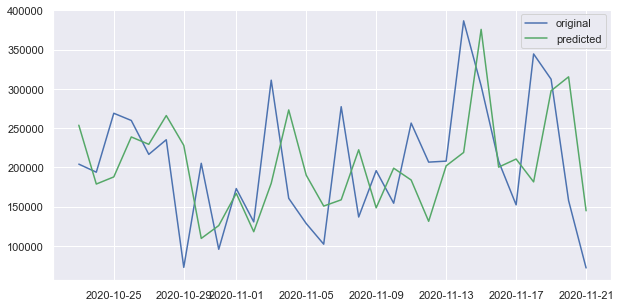

In [24]:
df_y_test_ = pd.DataFrame(y_test, columns = ['Sales'],index=pd.date_range(start=(df_cat_result.index.max() - dt.timedelta(days=test_days - 1)), periods=test_days, freq='D'))
df_pred_test_ = pd.DataFrame(y_pred_test, columns = ['Sales'], index=pd.date_range(start=(df_cat_result.index.max() - dt.timedelta(days=test_days - 1)), periods=test_days, freq='D'))

plt.figure(figsize=(10,5))
plt.plot(df_y_test_,label = 'original', color='b' )
plt.plot(df_pred_test_,label = 'predicted', color='g' )
plt.legend()

In [25]:
display(df_cat_result.head(5))

,price
2020-01-05,371539.63
2020-01-06,332321.50
2020-01-07,399448.31
2020-01-08,281893.94
2020-01-09,235279.72


### Step 4: XGBoost Regress Forecast for 30 days

In [26]:
lag_days = 9
forecast_days = 30
view_days = 90

def MultipleStepForecast(data, step_n):
    prediction_list = list()
    train = asarray(data)
    history = train[:, -1]
    for i in range(step_n):
        trainX,trainy = train[:,:-1], train[:, -1]
        testX = train[-1, 1:]
        #model = best_model
        model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth =10, random_state = 42)
        model.fit(trainX, trainy)
        y_pred = model.predict(asarray([testX]))
        prediction_list.append(y_pred[0])
        an_array = np.hstack([testX,y_pred])
        train = np.append(train, [an_array], axis=0)

    return history, prediction_list

def MultipleStepForecastWithBestModel(data, step_n, best_model):
    prediction_list = list()
    train = asarray(data)
    history = train[:, -1]
    for i in range(step_n):
        trainX,trainy = train[:,:-1], train[:, -1]
        testX = train[-1, 1:]
        model = best_model
        #model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth =10, random_state = 42)
        model.fit(trainX, trainy)
        y_pred = model.predict(asarray([testX]))
        prediction_list.append(y_pred[0])
        an_array = np.hstack([testX,y_pred])
        train = np.append(train, [an_array], axis=0)

    return history, prediction_list

def PlotForecastChart(history, prediction, columnName, df_original):
    df_history_ = pd.DataFrame(history, columns = [columnName],index=pd.date_range(start=(df_original.index.min() + dt.timedelta(days=lag_days)), periods=len(history), freq='D'))
    df_predict_ = pd.DataFrame(prediction, columns = [columnName], index=pd.date_range(start=(df_history_.index.max() + dt.timedelta(days=1)), periods=len(prediction), freq='D'))
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(df_history_[view_days:], label='Expected')
    plt.plot(df_predict_, label='Predicted')
    plt.title(str(forecast_days) + '-Sales Trend Forecasting for Category {0}'.format(cat))
    plt.ylabel('Sales (RM)')
    plt.xlabel('Date')
    plt.legend()
    plt.show()


In [27]:
data = series_to_supervised(df_cat_result, lag_days)
history2, predictions2 = MultipleStepForecast(data, forecast_days)

#display(history2)
#display(predictions2)

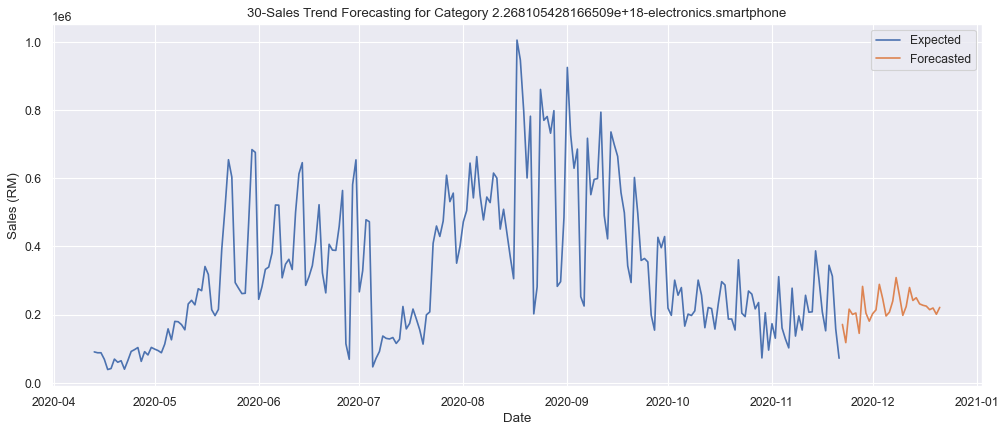

In [28]:
#df_history_ = pd.DataFrame(history2, columns = ['Sales'])
#df_predict_ = pd.DataFrame(predictions2, columns = ['Sales'], index=range(len(history2), len(history2)+len(predictions2)))

df_history_ = pd.DataFrame(history2, columns = ['Sales'],index=pd.date_range(start=(df_cat_result.index.min() + dt.timedelta(days=lag_days)), periods=len(history2), freq='D'))
df_predict_ = pd.DataFrame(predictions2, columns = ['Sales'], index=pd.date_range(start=(df_history_.index.max() + dt.timedelta(days=1)), periods=len(predictions2), freq='D'))

#display(df_predict_)
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(df_history_[view_days:], label='Expected')
plt.plot(df_predict_, label='Forecasted')
plt.title(str(forecast_days) + '-Sales Trend Forecasting for Category {0}'.format(cat))
plt.ylabel('Sales (RM)')
plt.xlabel('Date')
plt.legend()
plt.show()


XGBoost result is more promising than ARIMA in this. The XGBoost model will be further used for predict other category.

***

# Electronic Category Information Forecasting

(optional) Test XGBoost regressor model with different categories.

Electronic Category Analysis and Forecasting



Enter the category: 2.2681054418567176e+18-appliances.kitchen.kettle


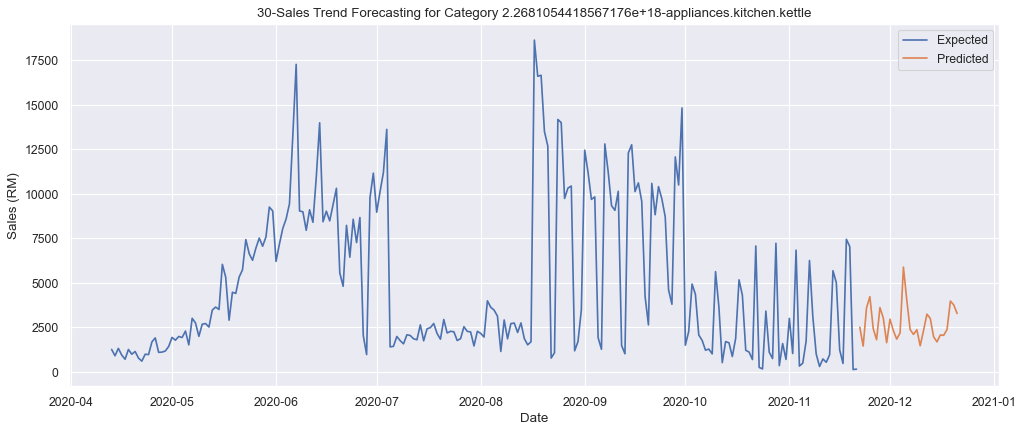

In [246]:
##Example
#2.268105428166509e+18-electronics.smartphone	302.831564	46.04	2314.79	335709
#2.2681054301629978e+18-electronics.audio.headphone	65.115374	0.23	810.16	65637
#2.3744989140005924e+18-electronics.video.tv	458.729482	92.57	50925.90	58804
#2.268105392070329e+18-appliances.environment.vacuum	155.693218	37.01	2474.51	58127
#2.2681053899563999e+18-appliances.kitchen.washer	347.419603	90.02	4629.58	51527
#2.268105442636858e+18-furniture.kitchen.table	32.931493	8.89	324.05	49491
#2.2681054418567176e+18-appliances.kitchen.kettle	34.070708	4.61	405.07	47723
#2.2681054072201554e+18-computers.notebook	646.389867	0.00	5370.35	47155
#2.268105393848714e+18-appliances.kitchen.refrigerators	528.568818	92.57	9173.59	44634
#2.2681054411017428e+18-appliances.kitchen.blender	66.642515	17.34	821.74	36540

print('Electronic Category Analysis and Forecasting')
print('')
print('')
print('')
cat = input("Enter the category: ")

df_cat_result_ = ConstructCategoryDateData(df_cleaned, cat, 'event_time', 'price')

data_ = series_to_supervised(df_cat_result_, lag_days)
##best_model_ = XGBoostGridSearch(df_cat_result_, lag_days, test_days) #For Dynamic best model
##history_, predictions_ = MultipleStepForecastWithBestModel(data_, forecast_days, best_model_) #For Dynamic best model
history_, predictions_ = MultipleStepForecast(data_, forecast_days)
PlotForecastChart(history_, predictions_, 'Sale', df_cat_result_)
